设 $\Omega=[0,1]^2$，真解 $u=[x_1(1-x_1)x_2(1-x_2),0]$。$u$ 的选择确保了在边界 $\partial\Omega$ 上 $u=0$。

$$f = 
\begin{bmatrix}
35/13x_2-35/13x_2^2+10/13x_1-10/13x_1^2\\
-25/26(-1+2x_2)(-1+2x_1)
\end{bmatrix}$$
其中 $E=1$ 和 $\nu=0.3$。

In [6]:
p = 1
GD = 2
n = 1
doforder = 'vdims'

In [7]:
from linear_elasticity_model2d import BoxDomainData2d

pde = BoxDomainData2d()

mu = pde.mu
lambda_ = pde.lam
domain = pde.domain()
mesh = pde.init_mesh(n=n)
NC = mesh.number_of_cells()
print("NC:", NC)
NN = mesh.number_of_nodes()
print("NN:", NN)

NC: 696
NN: 371


In [8]:
from fealpy.functionspace import LagrangeFESpace as Space

space = Space(mesh, p=p, doforder=doforder)
uh = space.function(dim=GD)
print("uh:", uh.shape)
vspace = GD*(space, )
gdof = vspace[0].number_of_global_dofs()
vgdof = gdof * GD
print("vgdof:", vgdof)
ldof = vspace[0].number_of_local_dofs()
vldof = ldof * GD
print("vldof:", vldof)

uh: (371, 2)
vgdof: 742
vldof: 6


In [9]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

import numpy as np

from fealpy.functionspace import LagrangeFESpace as Space
from fealpy.fem import LinearElasticityOperatorIntegrator
from fealpy.fem import BilinearForm
from fealpy.fem import VectorSourceIntegrator
from fealpy.fem import LinearForm


maxit = 4
errorType = ['$|| uh - u ||_{l_2}$']
errorMatrix = np.zeros((1, maxit), dtype=np.float64)
NDof = np.zeros(maxit, dtype=np.int_)
for i in range(maxit):
    space = Space(mesh, p=p, doforder=doforder)
    uh = space.function(dim=GD)
    vspace = GD*(space, )
    gdof = vspace[0].number_of_global_dofs()
    vgdof = gdof * GD
    print("vgdof:", vgdof)
    ldof = vspace[0].number_of_local_dofs()
    vldof = ldof * GD
    NDof[i] = vspace[0].number_of_global_dofs()

    integrator1 = LinearElasticityOperatorIntegrator(
                lam=lambda_, mu=mu, q=p+1
                                                    )
    bform = BilinearForm(vspace)
    bform.add_domain_integrator(integrator1)
    KK = integrator1.assembly_cell_matrix(space=vspace)
    K = bform.assembly()

    integrator3 = VectorSourceIntegrator(f = pde.source, q=5)
    lform = LinearForm(vspace)
    lform.add_domain_integrator(integrator3)
    FK = integrator3.assembly_cell_vector(space = vspace)
    F = lform.assembly()

    dflag = vspace[0].boundary_interpolate(
        gD=pde.dirichlet, uh=uh,
        threshold=pde.is_dirichlet_boundary)
    ipoints = vspace[0].interpolation_points()
    uh[dflag] = pde.dirichlet(ipoints[dflag])
    
    F -= K@uh.flat
    F[dflag.flat] = uh.ravel()[dflag.flat]

    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1

    uh.flat[:] = spsolve(K, F)
    u_exact = space.interpolate(pde.solution)

    errorMatrix[0, i] = np.max(np.abs(uh-u_exact))
    if i < maxit-1:
        mesh.uniform_refine()

print("errorMatrix:", errorMatrix)
print("ratio:", errorMatrix[:, 0:-1]/errorMatrix[:, 1:])

vgdof: 742
vgdof: 2874
vgdof: 11314
vgdof: 44898
errorMatrix: [[4.13282337e-04 1.54282144e-04 5.24937388e-05 1.69026418e-05]]
ratio: [[2.67874381 2.93905802 3.10565292]]


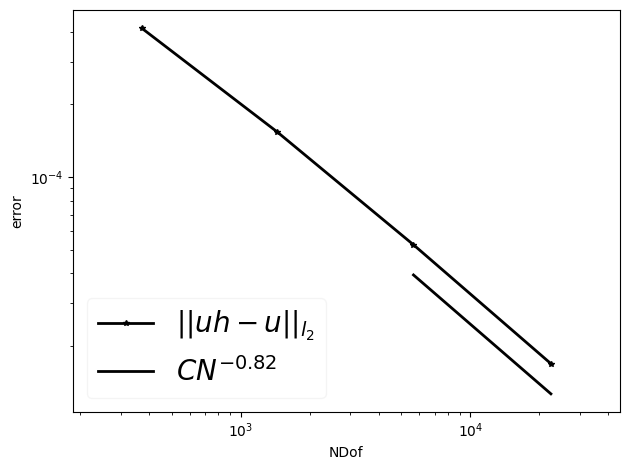

In [10]:
from fealpy.tools.show import showmultirate
import matplotlib.pyplot as plt

showmultirate(plt, 2, NDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.xlabel('NDof')
plt.ylabel('error')
plt.tight_layout()
plt.show()

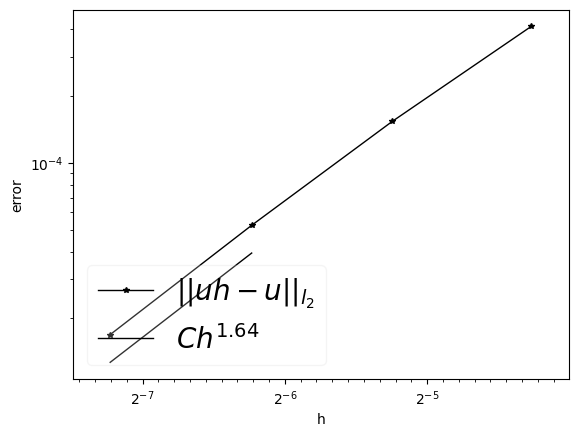

In [11]:
h = 1 / (np.power(NDof, 1/2))     
showmultirate(plt, 2, h, errorMatrix,  errorType, propsize=20)
plt.xlabel('h')
plt.ylabel('error')
plt.show()